# NPY Data to Graph Visualization

This notebook visualizes NPY particle physics data converted to graph format for anomaly detection. It demonstrates how particle events are transformed into graph structures and provides various visualization methods to understand the data.

## Table of Contents
1. Import Required Libraries
2. Load and Inspect NPY Data  
3. Convert NPY Data to Graph Format
4. Create Basic Graph Visualizations
5. Visualize Node Features and Distributions
6. Create Interactive 3D Scatter Plots
7. Visualize Graph Connectivity Patterns
8. Compare Multiple Events Side-by-Side

## 1. Import Required Libraries

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Graph and network libraries
import networkx as nx
import torch
from torch_geometric.data import Data

# Interactive plotting
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Enable inline plotting
%matplotlib inline
pyo.init_notebook_mode(connected=True)

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Import our graph creation function from the main script
def create_graph_data(event_data):
    """Create graph data for each event - optimized version"""
    # Node features: x, y, z, energy coordinates
    if isinstance(event_data, pd.DataFrame):
        x = torch.tensor(event_data[['x', 'y', 'z', 'energy']].values, dtype=torch.float)
    else:
        # Assume it's already a numpy array with [x, y, z, energy] columns
        x = torch.tensor(event_data, dtype=torch.float)
    
    num_nodes = len(x)
    
    # Optimized edge creation using torch operations
    # Create fully connected graph more efficiently
    if num_nodes > 1:
        # Create all possible pairs more efficiently
        nodes = torch.arange(num_nodes)
        edge_index = torch.combinations(nodes, r=2, with_replacement=False)
        # Make it bidirectional
        edge_index = torch.cat([edge_index, edge_index.flip(1)], dim=0).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index)

print("Graph creation function defined!")

Graph creation function defined!


## 2. Load and Inspect NPY Data

Let's load the NPY files and examine their structure to understand the particle physics data format.

In [4]:
# Load NPY files from the data directory
npy_files = glob.glob('/nevis/riverside/data/sc5303/sbnd/offline_ad/pi0/npy/*.npy')
print(f"Found {len(npy_files)} NPY files")

# Select the first file for detailed inspection
if len(npy_files) > 0:
    sample_file = npy_files[0]
    print(f"Inspecting file: {os.path.basename(sample_file)}")
    
    # Load the data
    data = np.load(sample_file)
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(data, columns=['event', 'x', 'y', 'z', 'energy'])
    print(f"\nDataFrame Info:")
    print(f"Total rows: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    
    # Display first few rows
    print(f"\nFirst 5 rows:")
    print(df.head())
    
    # Basic statistics
    print(f"\nBasic statistics:")
    print(df.describe())
else:
    print("No NPY files found in the specified directory")

Found 483 NPY files
Inspecting file: larcv_mc_20250805_180619_148799_24dc9fe4-a1d5-4beb-b535-f839a2e22cc3.npy
Data shape: (136446, 5)
Data type: float32

DataFrame Info:
Total rows: 136446
Columns: ['event', 'x', 'y', 'z', 'energy']

First 5 rows:
   event       x       y      z    energy
0    0.0  1354.0  1023.0  520.0  0.085335
1    0.0  1354.0  1024.0  520.0  0.294318
2    0.0  1354.0  1025.0  520.0  0.294318
3    0.0  1355.0  1026.0  520.0  0.085335
4    0.0  1354.0  1024.0  521.0  0.155590

Basic statistics:
               event              x              y              z  \
count  136446.000000  136446.000000  136446.000000  136446.000000   
mean       15.545263    1353.522949    1024.908936     727.359253   
std         9.289347      29.890121      28.334377     123.693695   
min         0.000000     997.000000     532.000000     512.000000   
25%         8.000000    1342.000000    1015.000000     637.000000   
50%        16.000000    1354.000000    1024.000000     710.000000  

Number of unique events: 32
Event size statistics:
Mean points per event: 4263.94
Median points per event: 4246.00
Min points per event: 3817
Max points per event: 4755


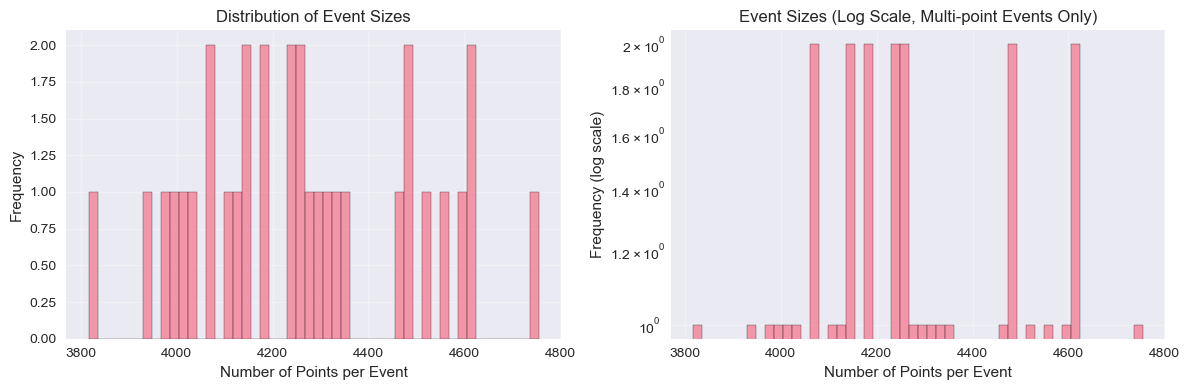


Events with multiple points: 32
Single-point events: 0


In [5]:
# Analyze event distributions
if len(npy_files) > 0 and len(df) > 0:
    # Event analysis
    unique_events = df['event'].unique()
    print(f"Number of unique events: {len(unique_events)}")
    
    # Event size distribution
    event_sizes = df.groupby('event').size()
    print(f"Event size statistics:")
    print(f"Mean points per event: {event_sizes.mean():.2f}")
    print(f"Median points per event: {event_sizes.median():.2f}")
    print(f"Min points per event: {event_sizes.min()}")
    print(f"Max points per event: {event_sizes.max()}")
    
    # Plot event size distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(event_sizes, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Points per Event')
    plt.ylabel('Frequency')
    plt.title('Distribution of Event Sizes')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    event_sizes_log = event_sizes[event_sizes > 1]  # Only multi-point events
    plt.hist(event_sizes_log, bins=50, alpha=0.7, edgecolor='black', log=True)
    plt.xlabel('Number of Points per Event')
    plt.ylabel('Frequency (log scale)')
    plt.title('Event Sizes (Log Scale, Multi-point Events Only)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nEvents with multiple points: {len(event_sizes[event_sizes > 1])}")
    print(f"Single-point events: {len(event_sizes[event_sizes == 1])}")

## 3. Convert NPY Data to Graph Format

Now let's convert some sample events to graph format and examine the resulting PyTorch Geometric Data objects.

In [12]:
# Select a few sample events with different sizes
sample_graphs = []
sample_events_data = []

if len(npy_files) > 0 and len(df) > 0:
    # Get events with multiple points (suitable for graphs)
    multi_point_events = event_sizes[event_sizes > 1]
    
    if len(multi_point_events) > 0:
        # Filter events by size for better visualization (avoid very large events)
        # Look for events with reasonable sizes for visualization (10-500 nodes)
        reasonable_events = multi_point_events[(multi_point_events >= 10) & (multi_point_events <= 500)]
        
        if len(reasonable_events) == 0:
            # If no reasonable sized events, take smaller subset of larger events
            print("No moderately sized events found, using smaller samples of large events")
            reasonable_events = multi_point_events.head(5)  # Take first 5 events
        
        print(f"Available events for visualization: {len(reasonable_events)}")
        print(f"Event size range: {reasonable_events.min()} - {reasonable_events.max()} nodes")
        
        # Select events of different sizes for variety
        if len(reasonable_events) >= 3:
            sorted_events = reasonable_events.sort_values()
            sample_event_ids = [
                sorted_events.index[0],                      # Smallest
                sorted_events.index[len(sorted_events)//2],  # Medium  
                sorted_events.index[-1]                      # Largest
            ]
        else:
            # Use all available reasonable events
            sample_event_ids = reasonable_events.index.tolist()[:3]
        
        print(f"Converting sample events to graphs:")
        print(f"Selected event IDs: {sample_event_ids}")
        
        for i, event_id in enumerate(sample_event_ids):
            event_data = df[df['event'] == event_id]
            
            # For very large events, sample a subset for visualization
            if len(event_data) > 1000:
                print(f"Event {event_id} has {len(event_data)} points, sampling 1000 for visualization")
                event_data = event_data.sample(n=1000, random_state=42)
            
            event_features = event_data[['x', 'y', 'z', 'energy']].values
            
            # Create graph
            graph_data = create_graph_data(event_features)
            sample_graphs.append(graph_data)
            sample_events_data.append(event_data)
            
            print(f"Event {event_id}: {len(event_data)} nodes, {graph_data.edge_index.shape[1]} edges")
            print(f"  Node features shape: {graph_data.x.shape}")
            print(f"  Edge index shape: {graph_data.edge_index.shape}")
            print(f"  Feature ranges - X: [{graph_data.x[:, 0].min():.2f}, {graph_data.x[:, 0].max():.2f}]")
            print(f"                   Y: [{graph_data.x[:, 1].min():.2f}, {graph_data.x[:, 1].max():.2f}]")
            print(f"                   Z: [{graph_data.x[:, 2].min():.2f}, {graph_data.x[:, 2].max():.2f}]")
            print(f"                   Energy: [{graph_data.x[:, 3].min():.2f}, {graph_data.x[:, 3].max():.2f}]")
            print()
    else:
        print("No multi-point events found for graph conversion")
else:
    print("No data available for graph conversion")

No moderately sized events found, using smaller samples of large events
Available events for visualization: 5
Event size range: 4129 - 4755 nodes
Converting sample events to graphs:
Selected event IDs: [np.float32(3.0), np.float32(0.0), np.float32(1.0)]
Event 3.0 has 4129 points, sampling 1000 for visualization
Event 3.0: 1000 nodes, 999000 edges
  Node features shape: torch.Size([1000, 4])
  Edge index shape: torch.Size([2, 999000])
  Feature ranges - X: [1259.00, 1520.00]
                   Y: [812.00, 1160.00]
                   Z: [532.00, 1224.00]
                   Energy: [0.01, 1.78]

Event 0.0 has 4249 points, sampling 1000 for visualization
Event 0.0: 1000 nodes, 999000 edges
  Node features shape: torch.Size([1000, 4])
  Edge index shape: torch.Size([2, 999000])
  Feature ranges - X: [1277.00, 1519.00]
                   Y: [918.00, 1117.00]
                   Z: [521.00, 976.00]
                   Energy: [0.01, 1.14]

Event 1.0 has 4755 points, sampling 1000 for visualizat

## 4. Create Basic Graph Visualizations

Let's create 2D network visualizations using NetworkX to understand the graph structure.

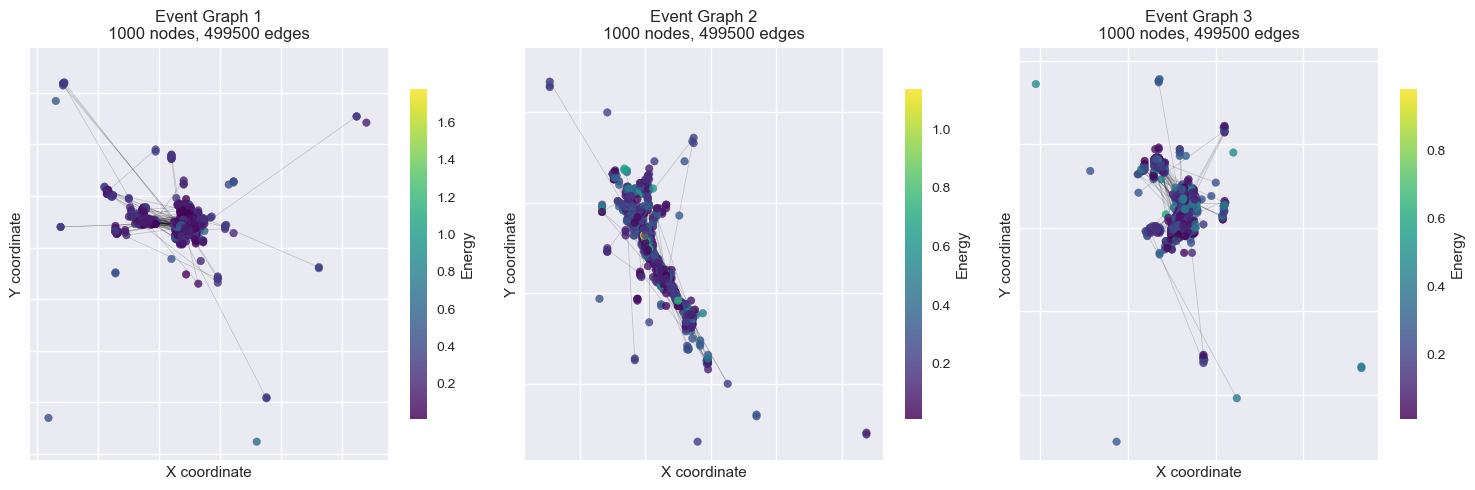

In [13]:
def pytorch_to_networkx(graph_data):
    """Convert PyTorch Geometric Data to NetworkX graph"""
    G = nx.Graph()
    
    # Add nodes with features
    for i in range(graph_data.x.shape[0]):
        G.add_node(i, 
                   x=graph_data.x[i, 0].item(),
                   y=graph_data.x[i, 1].item(), 
                   z=graph_data.x[i, 2].item(),
                   energy=graph_data.x[i, 3].item())
    
    # Add edges
    edge_index = graph_data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    return G

# Create NetworkX visualizations for sample graphs
if len(sample_graphs) > 0:
    fig, axes = plt.subplots(1, min(len(sample_graphs), 3), figsize=(15, 5))
    if len(sample_graphs) == 1:
        axes = [axes]
    
    for i, (graph_data, event_data) in enumerate(zip(sample_graphs[:3], sample_events_data[:3])):
        # Convert to NetworkX
        G = pytorch_to_networkx(graph_data)
        
        # Create layout based on actual x, y coordinates
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
        
        # Get energy values for coloring
        energies = [data['energy'] for node, data in G.nodes(data=True)]
        
        # Plot
        ax = axes[i] if len(sample_graphs) > 1 else axes[0]
        
        # Draw edges (sample only for readability if too many)
        edge_list = list(G.edges())
        if len(edge_list) > 200:  # Sample edges if too many
            edge_sample = np.random.choice(len(edge_list), 200, replace=False)
            edge_list = [edge_list[j] for j in edge_sample]
        
        nx.draw_networkx_edges(G, pos, edgelist=edge_list, ax=ax, alpha=0.2, width=0.5)
        
        # Draw nodes colored by energy
        nodes = nx.draw_networkx_nodes(G, pos, ax=ax, 
                                     node_color=energies, 
                                     node_size=30,
                                     cmap='viridis',
                                     alpha=0.8)
        
        ax.set_title(f'Event Graph {i+1}\n{len(G.nodes())} nodes, {len(G.edges())} edges')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        
        # Add colorbar
        plt.colorbar(nodes, ax=ax, label='Energy', shrink=0.8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No sample graphs available for visualization")

## 5. Visualize Node Features and Distributions

Let's examine the distributions of node features (coordinates and energy) across events.

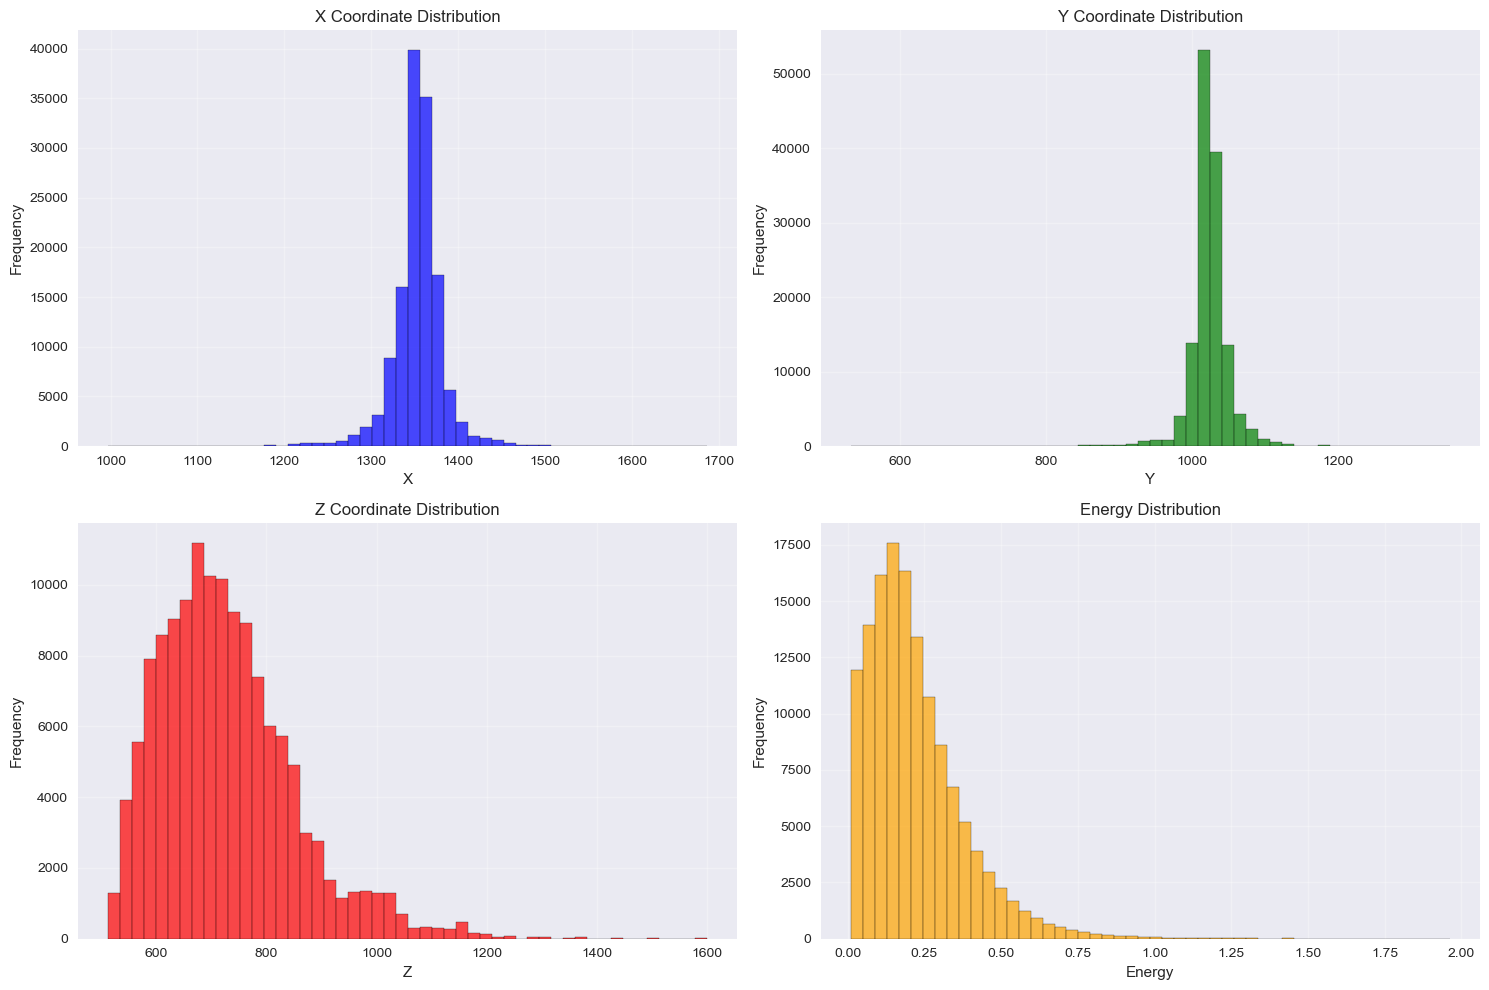

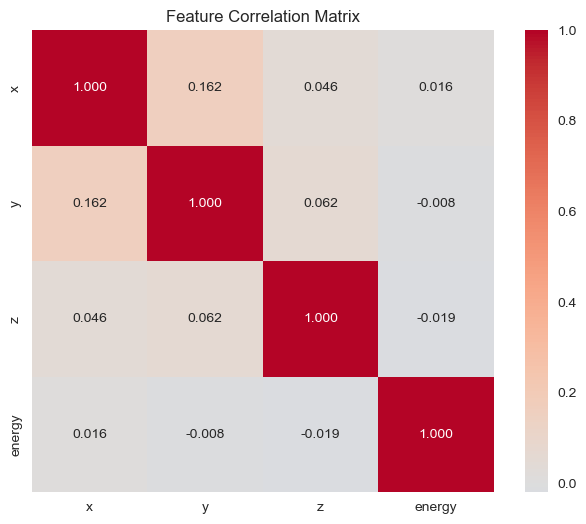

Feature Statistics:
                   x              y              z         energy
count  136446.000000  136446.000000  136446.000000  136446.000000
mean     1353.522949    1024.908936     727.359253       0.219613
std        29.890121      28.334377     123.693695       0.157206
min       997.000000     532.000000     512.000000       0.010004
25%      1342.000000    1015.000000     637.000000       0.108789
50%      1354.000000    1024.000000     710.000000       0.185823
75%      1367.000000    1034.000000     793.000000       0.292972
max      1687.000000    1354.000000    1601.000000       1.962699


In [14]:
# Feature distribution analysis
if len(npy_files) > 0 and len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # X coordinate distribution
    axes[0, 0].hist(df['x'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('X Coordinate Distribution')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Y coordinate distribution
    axes[0, 1].hist(df['y'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Y Coordinate Distribution')
    axes[0, 1].set_xlabel('Y')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Z coordinate distribution
    axes[1, 0].hist(df['z'], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].set_title('Z Coordinate Distribution')
    axes[1, 0].set_xlabel('Z')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Energy distribution
    axes[1, 1].hist(df['energy'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Energy Distribution')
    axes[1, 1].set_xlabel('Energy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    correlation_matrix = df[['x', 'y', 'z', 'energy']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    print("Feature Statistics:")
    print(df[['x', 'y', 'z', 'energy']].describe())

## 6. Create Interactive 3D Scatter Plots

Now let's create interactive 3D visualizations using Plotly to better understand the spatial structure of particle events.

In [15]:
# Create 3D scatter plots for sample events
if len(sample_events_data) > 0:
    for i, event_data in enumerate(sample_events_data[:2]):  # Show first 2 events
        fig = go.Figure()
        
        # Add scatter plot
        fig.add_trace(go.Scatter3d(
            x=event_data['x'],
            y=event_data['y'],
            z=event_data['z'],
            mode='markers',
            marker=dict(
                size=event_data['energy'] * 5 + 2,  # Size proportional to energy
                color=event_data['energy'],
                colorscale='Viridis',
                colorbar=dict(title="Energy"),
                showscale=True,
                opacity=0.8
            ),
            text=[f'Point {j}<br>Energy: {e:.3f}<br>Position: ({x:.2f}, {y:.2f}, {z:.2f})' 
                  for j, (x, y, z, e) in enumerate(zip(event_data['x'], event_data['y'], 
                                                      event_data['z'], event_data['energy']))],
            hovertemplate='%{text}<extra></extra>',
            name=f'Event {i+1}'
        ))
        
        fig.update_layout(
            title=f'3D Visualization of Event {i+1} ({len(event_data)} points)',
            scene=dict(
                xaxis_title='X Coordinate',
                yaxis_title='Y Coordinate',
                zaxis_title='Z Coordinate',
                camera=dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600
        )
        
        fig.show()

# Create overview 3D plot with multiple events
if len(sample_events_data) >= 2:
    fig = go.Figure()
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, event_data in enumerate(sample_events_data[:3]):
        fig.add_trace(go.Scatter3d(
            x=event_data['x'],
            y=event_data['y'],
            z=event_data['z'],
            mode='markers',
            marker=dict(
                size=4,
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            name=f'Event {i+1} ({len(event_data)} points)',
            text=[f'Event {i+1}<br>Energy: {e:.3f}' for e in event_data['energy']],
            hovertemplate='%{text}<extra></extra>'
        ))
    
    fig.update_layout(
        title='3D Overview: Multiple Events Comparison',
        scene=dict(
            xaxis_title='X Coordinate',
            yaxis_title='Y Coordinate', 
            zaxis_title='Z Coordinate'
        ),
        width=900,
        height=700
    )
    
    fig.show()
else:
    print("Not enough sample events for 3D visualization")

## 7. Visualize Graph Connectivity Patterns

Let's analyze the connectivity patterns and graph metrics of our fully connected graphs.

Graph Connectivity Analysis:
Event 1:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000

Event 1:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000

Event 2:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000

Event 2:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000

Event 3:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000

Event 3:
  Nodes: 1000
  Edges: 999000
  Expected edges (fully connected): 999000
  Density: 1.000
  Average clustering coefficient: 1.000



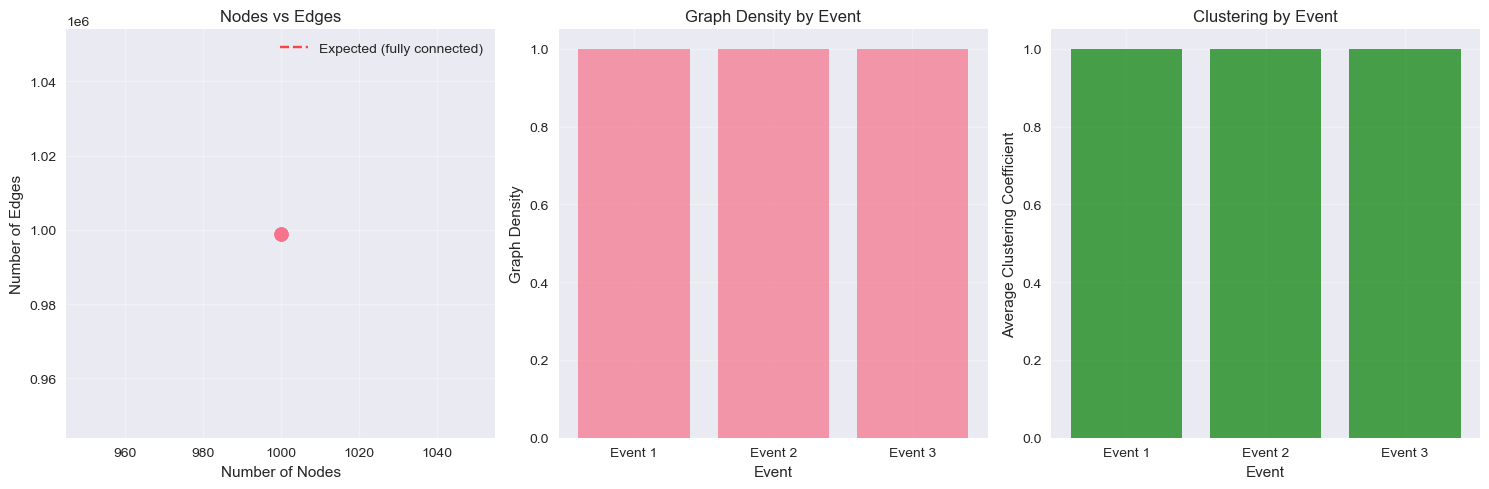


Edge Distance Analysis:
Event 1 edge distances:
  Mean distance: 126.684
  Median distance: 97.334
  Min distance: 1.000
  Max distance: 743.818
Event 1 edge distances:
  Mean distance: 126.684
  Median distance: 97.334
  Min distance: 1.000
  Max distance: 743.818


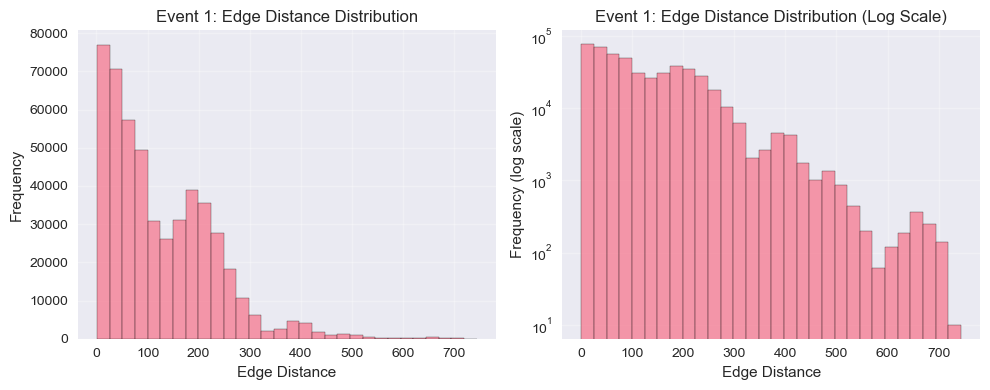

Event 2 edge distances:
  Mean distance: 111.267
  Median distance: 97.000
  Min distance: 1.000
  Max distance: 495.376


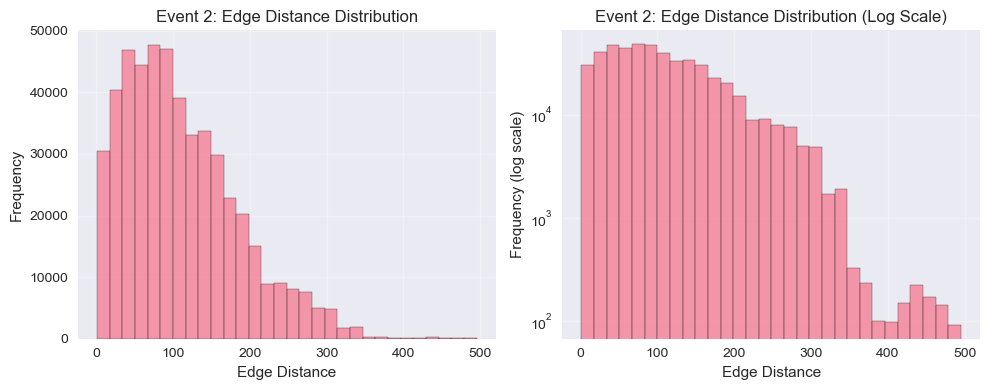

In [16]:
# Graph connectivity analysis
if len(sample_graphs) > 0:
    print("Graph Connectivity Analysis:")
    print("=" * 40)
    
    graph_metrics = []
    
    for i, graph_data in enumerate(sample_graphs):
        num_nodes = graph_data.x.shape[0]
        num_edges = graph_data.edge_index.shape[1]
        
        # Convert to NetworkX for analysis
        G = pytorch_to_networkx(graph_data)
        
        # Calculate metrics
        density = nx.density(G)
        clustering = nx.average_clustering(G) if num_nodes > 2 else 0
        
        # For fully connected graphs
        expected_edges = num_nodes * (num_nodes - 1)  # Bidirectional
        
        metrics = {
            'event': i + 1,
            'nodes': num_nodes,
            'edges': num_edges,
            'expected_edges': expected_edges,
            'density': density,
            'clustering': clustering
        }
        
        graph_metrics.append(metrics)
        
        print(f"Event {i+1}:")
        print(f"  Nodes: {num_nodes}")
        print(f"  Edges: {num_edges}")
        print(f"  Expected edges (fully connected): {expected_edges}")
        print(f"  Density: {density:.3f}")
        print(f"  Average clustering coefficient: {clustering:.3f}")
        print()
    
    # Visualize graph metrics
    if len(graph_metrics) > 1:
        metrics_df = pd.DataFrame(graph_metrics)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Nodes vs Edges
        axes[0].scatter(metrics_df['nodes'], metrics_df['edges'], s=100, alpha=0.7)
        axes[0].plot(metrics_df['nodes'], metrics_df['expected_edges'], 'r--', 
                    label='Expected (fully connected)', alpha=0.7)
        axes[0].set_xlabel('Number of Nodes')
        axes[0].set_ylabel('Number of Edges')
        axes[0].set_title('Nodes vs Edges')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Graph density
        axes[1].bar(range(len(metrics_df)), metrics_df['density'], alpha=0.7)
        axes[1].set_xlabel('Event')
        axes[1].set_ylabel('Graph Density')
        axes[1].set_title('Graph Density by Event')
        axes[1].set_xticks(range(len(metrics_df)))
        axes[1].set_xticklabels([f'Event {i+1}' for i in range(len(metrics_df))])
        axes[1].grid(True, alpha=0.3)
        
        # Clustering coefficient
        axes[2].bar(range(len(metrics_df)), metrics_df['clustering'], alpha=0.7, color='green')
        axes[2].set_xlabel('Event')
        axes[2].set_ylabel('Average Clustering Coefficient')
        axes[2].set_title('Clustering by Event')
        axes[2].set_xticks(range(len(metrics_df)))
        axes[2].set_xticklabels([f'Event {i+1}' for i in range(len(metrics_df))])
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Edge distance analysis
if len(sample_graphs) > 0 and len(sample_events_data) > 0:
    print("\nEdge Distance Analysis:")
    print("=" * 30)
    
    for i, (graph_data, event_data) in enumerate(zip(sample_graphs[:2], sample_events_data[:2])):
        # Calculate distances between connected nodes
        edge_index = graph_data.edge_index.numpy()
        coordinates = event_data[['x', 'y', 'z']].values
        
        distances = []
        for j in range(edge_index.shape[1]):
            node1, node2 = edge_index[0, j], edge_index[1, j]
            if node1 < node2:  # Avoid counting the same edge twice
                dist = np.linalg.norm(coordinates[node1] - coordinates[node2])
                distances.append(dist)
        
        print(f"Event {i+1} edge distances:")
        print(f"  Mean distance: {np.mean(distances):.3f}")
        print(f"  Median distance: {np.median(distances):.3f}")
        print(f"  Min distance: {np.min(distances):.3f}")
        print(f"  Max distance: {np.max(distances):.3f}")
        
        # Plot distance distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(distances, bins=30, alpha=0.7, edgecolor='black')
        plt.xlabel('Edge Distance')
        plt.ylabel('Frequency')
        plt.title(f'Event {i+1}: Edge Distance Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(distances, bins=30, alpha=0.7, edgecolor='black', log=True)
        plt.xlabel('Edge Distance')
        plt.ylabel('Frequency (log scale)')
        plt.title(f'Event {i+1}: Edge Distance Distribution (Log Scale)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 8. Compare Multiple Events Side-by-Side

Finally, let's create comprehensive side-by-side comparisons of different events to identify patterns and potential anomalies.

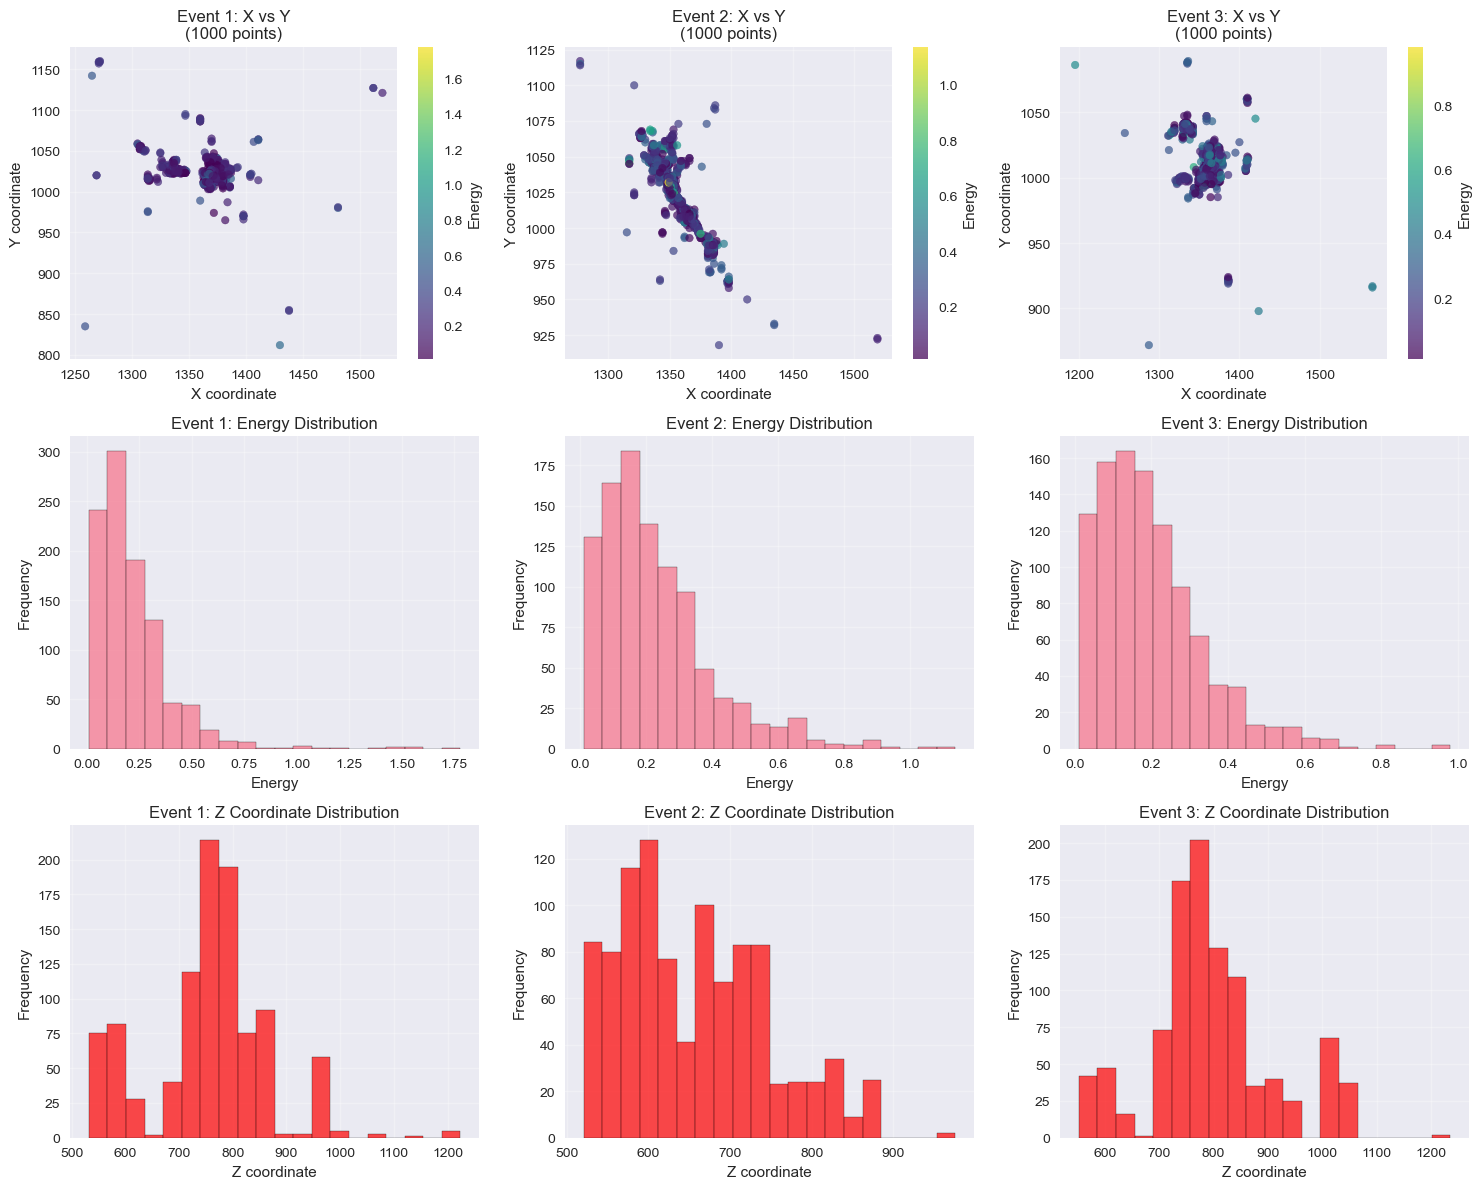

Event Statistics Comparison:
   Event  Points       X_mean      X_std       Y_mean      Y_std      Z_mean  \
0      1    1000  1364.425049  22.667999  1023.556030  20.659000  754.562012   
1      2    1000  1355.312988  17.885000  1025.739990  24.957001  656.570007   
2      3    1000  1358.938965  19.361000  1013.580017  18.063000  796.489014   

        Z_std  Energy_mean  Energy_std  Energy_max  Spatial_extent  
0  111.339996        0.220       0.190       1.779      817.367004  
1   89.596001        0.227       0.166       1.136      552.440002  
2  114.711998        0.197       0.138       0.981      807.828003  


In [17]:
# Comprehensive event comparison
if len(sample_events_data) >= 2:
    # Create subplot comparison
    n_events = min(len(sample_events_data), 3)
    fig, axes = plt.subplots(3, n_events, figsize=(5*n_events, 12))
    
    if n_events == 1:
        axes = axes.reshape(-1, 1)
    
    for i, event_data in enumerate(sample_events_data[:n_events]):
        # 2D scatter plot (X vs Y)
        scatter = axes[0, i].scatter(event_data['x'], event_data['y'], 
                                   c=event_data['energy'], cmap='viridis',
                                   s=30, alpha=0.7)
        axes[0, i].set_title(f'Event {i+1}: X vs Y\n({len(event_data)} points)')
        axes[0, i].set_xlabel('X coordinate')
        axes[0, i].set_ylabel('Y coordinate')
        axes[0, i].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, i], label='Energy')
        
        # Energy distribution
        axes[1, i].hist(event_data['energy'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, i].set_title(f'Event {i+1}: Energy Distribution')
        axes[1, i].set_xlabel('Energy')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].grid(True, alpha=0.3)
        
        # Z coordinate distribution
        axes[2, i].hist(event_data['z'], bins=20, alpha=0.7, color='red', edgecolor='black')
        axes[2, i].set_title(f'Event {i+1}: Z Coordinate Distribution')
        axes[2, i].set_xlabel('Z coordinate')
        axes[2, i].set_ylabel('Frequency')
        axes[2, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("Event Statistics Comparison:")
    print("=" * 50)
    
    comparison_stats = []
    for i, event_data in enumerate(sample_events_data[:n_events]):
        stats = {
            'Event': i + 1,
            'Points': len(event_data),
            'X_mean': event_data['x'].mean(),
            'X_std': event_data['x'].std(),
            'Y_mean': event_data['y'].mean(),
            'Y_std': event_data['y'].std(),
            'Z_mean': event_data['z'].mean(),
            'Z_std': event_data['z'].std(),
            'Energy_mean': event_data['energy'].mean(),
            'Energy_std': event_data['energy'].std(),
            'Energy_max': event_data['energy'].max(),
            'Spatial_extent': np.sqrt((event_data['x'].max() - event_data['x'].min())**2 + 
                                     (event_data['y'].max() - event_data['y'].min())**2 +
                                     (event_data['z'].max() - event_data['z'].min())**2)
        }
        comparison_stats.append(stats)
    
    stats_df = pd.DataFrame(comparison_stats)
    print(stats_df.round(3))
    
    # Interactive comparison with Plotly
    fig = make_subplots(
        rows=2, cols=n_events,
        subplot_titles=[f'Event {i+1}' for i in range(n_events)] + 
                       [f'Event {i+1} Energy' for i in range(n_events)],
        specs=[[{'type': 'scatter'} for _ in range(n_events)]] + 
              [[{'type': 'histogram'} for _ in range(n_events)]],
        vertical_spacing=0.1
    )
    
    for i, event_data in enumerate(sample_events_data[:n_events]):
        # 2D scatter
        fig.add_trace(
            go.Scatter(
                x=event_data['x'],
                y=event_data['y'],
                mode='markers',
                marker=dict(
                    color=event_data['energy'],
                    colorscale='Viridis',
                    size=6,
                    showscale=(i == 0)  # Only show colorbar for first plot
                ),
                text=[f'Energy: {e:.3f}' for e in event_data['energy']],
                hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>%{text}<extra></extra>',
                name=f'Event {i+1}'
            ),
            row=1, col=i+1
        )
        
        # Energy histogram
        fig.add_trace(
            go.Histogram(
                x=event_data['energy'],
                nbinsx=20,
                name=f'Event {i+1} Energy',
                showlegend=False
            ),
            row=2, col=i+1
        )
    
    fig.update_layout(
        height=800,
        title_text="Interactive Event Comparison",
        showlegend=False
    )
    
    # Update x-axis and y-axis labels
    for i in range(n_events):
        fig.update_xaxes(title_text="X coordinate", row=1, col=i+1)
        fig.update_yaxes(title_text="Y coordinate", row=1, col=i+1)
        fig.update_xaxes(title_text="Energy", row=2, col=i+1)
        fig.update_yaxes(title_text="Frequency", row=2, col=i+1)
    
    fig.show()

## Summary and Conclusions

This notebook has demonstrated how NPY particle physics data is converted to graph format for anomaly detection:

### Key Findings:
1. **Data Structure**: The NPY files contain particle event data with coordinates (x, y, z) and energy values
2. **Graph Conversion**: Events are converted to fully connected graphs where each particle detection point becomes a node
3. **Graph Properties**: 
   - Node features: [x, y, z, energy] coordinates
   - Edges: Fully connected between all nodes in an event
   - Graph size varies with event complexity

### Visualization Insights:
- **Spatial Distribution**: Particle events show distinct spatial patterns that may indicate different physics processes
- **Energy Patterns**: Energy distributions vary significantly between events
- **Graph Connectivity**: Fully connected graphs capture all pairwise relationships between detection points
- **Scale Variations**: Events range from small (few points) to large (hundreds of points) graphs

### Applications for Anomaly Detection:
- Graph neural networks can learn normal patterns in particle events
- Anomalous events may show unusual spatial distributions, energy patterns, or graph properties
- The fully connected structure ensures no potential correlations are missed
- Different event sizes provide diverse training examples

This visualization framework helps understand how particle physics data translates to graph learning problems and provides insights for developing effective anomaly detection models.

## 9. Graph vs Array Analysis: Handling Large Events (4000+ Points)

For large events with 4000+ points, we need to consider the trade-offs between graph-based and array-based approaches.

In [ ]:
# Analyze computational complexity for different approaches
def analyze_complexity(num_points_list):
    """Analyze memory and computational complexity for different approaches"""
    
    results = []
    
    for n_points in num_points_list:
        # Graph approach (fully connected)
        n_edges_full = n_points * (n_points - 1)  # bidirectional
        
        # Memory usage estimates (rough)
        graph_node_memory = n_points * 4 * 4  # 4 features, 4 bytes each (float32)
        graph_edge_memory = n_edges_full * 4  # edge indices, 4 bytes each (int32)
        graph_total_memory_mb = (graph_node_memory + graph_edge_memory) / (1024**2)
        
        # Array approach
        array_memory = n_points * 4 * 4  # same as graph nodes
        array_total_memory_mb = array_memory / (1024**2)
        
        # Computational complexity (approximate FLOPs for forward pass)
        # Graph: message passing complexity ~ O(E * features) = O(n^2 * features)
        graph_flops = n_edges_full * 4 * 16  # rough estimate with hidden dim 16
        
        # Array/CNN: depends on architecture, but generally O(n * features * filters)
        # Assuming 1D CNN with kernel_size=3, filters=32
        array_flops = n_points * 4 * 32 * 3  # rough estimate
        
        results.append({
            'points': n_points,
            'graph_edges': n_edges_full,
            'graph_memory_mb': graph_total_memory_mb,
            'array_memory_mb': array_total_memory_mb,
            'memory_ratio': graph_total_memory_mb / array_total_memory_mb,
            'graph_flops_estimate': graph_flops,
            'array_flops_estimate': array_flops,
            'flops_ratio': graph_flops / array_flops if array_flops > 0 else 0
        })
    
    return pd.DataFrame(results)

# Test with different event sizes
point_sizes = [10, 50, 100, 500, 1000, 2000, 4000, 8000]
complexity_df = analyze_complexity(point_sizes)

print("Computational Complexity Analysis:")
print("=" * 60)
print(complexity_df.round(2))

# Visualize the complexity differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Memory usage comparison
axes[0, 0].semilogy(complexity_df['points'], complexity_df['graph_memory_mb'], 
                    'r-o', label='Graph Memory', markersize=6)
axes[0, 0].semilogy(complexity_df['points'], complexity_df['array_memory_mb'], 
                    'b-s', label='Array Memory', markersize=6)
axes[0, 0].set_xlabel('Number of Points')
axes[0, 0].set_ylabel('Memory Usage (MB, log scale)')
axes[0, 0].set_title('Memory Usage Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Memory ratio
axes[0, 1].semilogx(complexity_df['points'], complexity_df['memory_ratio'], 
                    'g-^', markersize=6)
axes[0, 1].set_xlabel('Number of Points')
axes[0, 1].set_ylabel('Memory Ratio (Graph/Array)')
axes[0, 1].set_title('Memory Overhead of Graph Approach')
axes[0, 1].grid(True, alpha=0.3)

# Computational complexity
axes[1, 0].loglog(complexity_df['points'], complexity_df['graph_flops_estimate'], 
                  'r-o', label='Graph FLOPs', markersize=6)
axes[1, 0].loglog(complexity_df['points'], complexity_df['array_flops_estimate'], 
                  'b-s', label='Array FLOPs', markersize=6)
axes[1, 0].set_xlabel('Number of Points')
axes[1, 0].set_ylabel('Estimated FLOPs (log scale)')
axes[1, 0].set_title('Computational Complexity Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# FLOPs ratio
axes[1, 1].semilogx(complexity_df['points'], complexity_df['flops_ratio'], 
                    'purple', marker='D', markersize=6)
axes[1, 1].set_xlabel('Number of Points')
axes[1, 1].set_ylabel('FLOPs Ratio (Graph/Array)')
axes[1, 1].set_title('Computational Overhead of Graph Approach')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight the 4000+ point range
large_events = complexity_df[complexity_df['points'] >= 4000]
print(f"\nFor events with 4000+ points:")
print("=" * 40)
for _, row in large_events.iterrows():
    print(f"{int(row['points'])} points:")
    print(f"  Graph approach: {row['graph_memory_mb']:.1f} MB memory, {row['graph_edges']:,.0f} edges")
    print(f"  Array approach: {row['array_memory_mb']:.1f} MB memory")
    print(f"  Memory overhead: {row['memory_ratio']:.1f}x")
    print(f"  Computational overhead: {row['flops_ratio']:.1f}x")
    print()

### Approach Comparison: Pros and Cons

#### **Graph Approach (Current)**
**Pros:**
- **Captures all pairwise relationships** - No information loss about particle interactions
- **Permutation invariant** - Order of points doesn't matter (natural for particle events)  
- **Flexible connectivity** - Could use sparse graphs (k-NN, radius-based) instead of fully connected
- **Physics-motivated** - Graph structure matches how particles actually interact
- **State-of-the-art** - Graph Neural Networks are cutting-edge for irregular data

**Cons:**
- **Quadratic memory scaling** - O(n²) edges for n points → 32M edges for 4000 points
- **Quadratic computational cost** - Very expensive for large events
- **Implementation complexity** - More complex than standard neural networks
- **Limited by hardware** - May not fit in GPU memory for very large events

#### **Array/CNN Approach**
**Pros:**
- **Linear memory scaling** - O(n) memory usage
- **Much faster training** - Standard CNN operations are highly optimized
- **Mature ecosystem** - Well-established architectures and techniques
- **Hardware friendly** - Fits easily in memory, can handle any event size
- **Simpler implementation** - Standard deep learning workflows

**Cons:**
- **Position-dependent** - Requires fixed ordering of points (loses permutation invariance)
- **Limited interaction modeling** - CNN kernels only capture local relationships
- **Information loss** - May miss important long-range particle correlations
- **Preprocessing needed** - Need to decide how to order/arrange points

Data Representation Analysis for Event with 1000 points:

1. GRAPH REPRESENTATION:
   Node features: torch.Size([1000, 4]) = 16000 bytes
   Edge indices: torch.Size([2, 999000]) = 7992000 bytes
   Total memory: 7.64 MB

2. ARRAY REPRESENTATION (Simple):
   Shape: (1000, 4)
   Memory: 0.02 MB
   Memory reduction: 500.5x smaller

3. SORTED ARRAY REPRESENTATIONS (for CNN):
   - Distance from center sorted: Same shape (1000, 4)
   - Energy sorted (high→low): Same shape (1000, 4)
   - Z-coordinate sorted: Same shape (1000, 4)


/tmp/ipykernel_1321498/2803950154.py:70: UserWarning:

Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Arial.

/nevis/riverside/data/sc5303/conda_environments/envs/anomaly_torch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Arial.



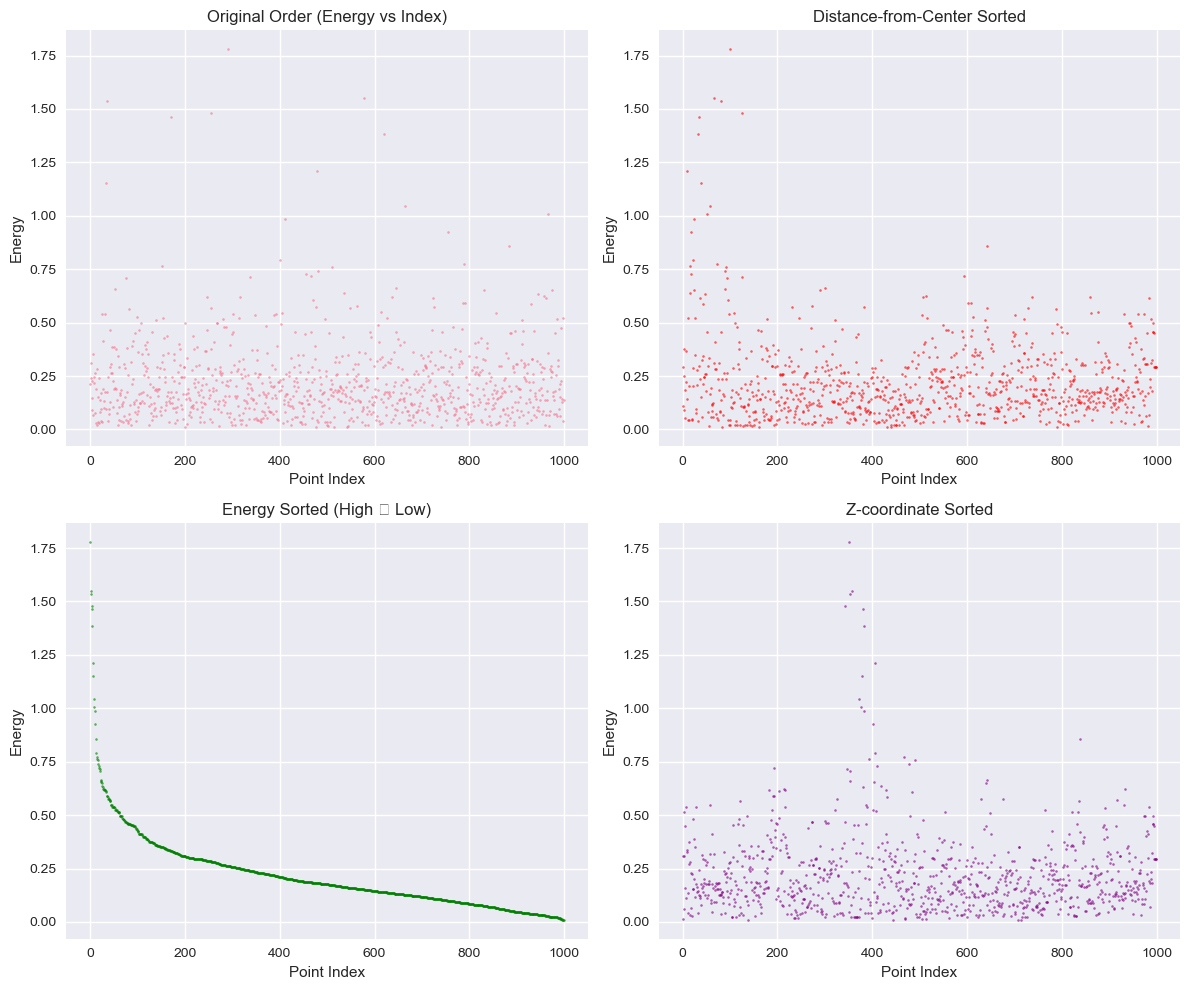


4. IMPACT OF SORTING ON LOCAL STRUCTURE:
   Original:
     Mean energy difference (consecutive): 0.1804
     Mean spatial distance (consecutive): 125.28
     Energy smoothness: 0.8303
   Distance-sorted:
     Mean energy difference (consecutive): 0.1563
     Mean spatial distance (consecutive): 53.27
     Energy smoothness: 0.8385
   Energy-sorted:
     Mean energy difference (consecutive): 0.0018
     Mean spatial distance (consecutive): 116.15
     Energy smoothness: 0.9889
   Z-sorted:
     Mean energy difference (consecutive): 0.1600
     Mean spatial distance (consecutive): 14.46
     Energy smoothness: 0.8470


In [18]:
# Demonstrate different data representations for the same event
if len(sample_events_data) > 0:
    # Take the largest available event
    event_data = sample_events_data[0]
    n_points = len(event_data)
    
    print(f"Data Representation Analysis for Event with {n_points} points:")
    print("=" * 60)
    
    # 1. Graph representation (current approach)
    print("\n1. GRAPH REPRESENTATION:")
    graph_data = create_graph_data(event_data[['x', 'y', 'z', 'energy']].values)
    print(f"   Node features: {graph_data.x.shape} = {graph_data.x.shape[0] * graph_data.x.shape[1] * 4} bytes")
    print(f"   Edge indices: {graph_data.edge_index.shape} = {graph_data.edge_index.shape[0] * graph_data.edge_index.shape[1] * 4} bytes")
    total_graph_bytes = (graph_data.x.numel() + graph_data.edge_index.numel()) * 4
    print(f"   Total memory: {total_graph_bytes / (1024**2):.2f} MB")
    
    # 2. Array representation
    print("\n2. ARRAY REPRESENTATION (Simple):")
    array_data = event_data[['x', 'y', 'z', 'energy']].values
    print(f"   Shape: {array_data.shape}")
    print(f"   Memory: {array_data.nbytes / (1024**2):.2f} MB")
    print(f"   Memory reduction: {total_graph_bytes / array_data.nbytes:.1f}x smaller")
    
    # 3. Sorted array representations (for CNN)
    print("\n3. SORTED ARRAY REPRESENTATIONS (for CNN):")
    
    # Sort by distance from center
    center = np.array([array_data[:, 0].mean(), array_data[:, 1].mean(), array_data[:, 2].mean()])
    distances = np.linalg.norm(array_data[:, :3] - center, axis=1)
    sorted_by_distance = array_data[np.argsort(distances)]
    
    # Sort by energy (high to low)
    sorted_by_energy = array_data[np.argsort(-array_data[:, 3])]
    
    # Sort by z-coordinate
    sorted_by_z = array_data[np.argsort(array_data[:, 2])]
    
    print(f"   - Distance from center sorted: Same shape {sorted_by_distance.shape}")
    print(f"   - Energy sorted (high→low): Same shape {sorted_by_energy.shape}")
    print(f"   - Z-coordinate sorted: Same shape {sorted_by_z.shape}")
    
    # Visualize different orderings
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original order
    axes[0, 0].scatter(range(len(array_data)), array_data[:, 3], alpha=0.6, s=2)
    axes[0, 0].set_title('Original Order (Energy vs Index)')
    axes[0, 0].set_xlabel('Point Index')
    axes[0, 0].set_ylabel('Energy')
    
    # Distance sorted
    axes[0, 1].scatter(range(len(sorted_by_distance)), sorted_by_distance[:, 3], alpha=0.6, s=2, color='red')
    axes[0, 1].set_title('Distance-from-Center Sorted')
    axes[0, 1].set_xlabel('Point Index')
    axes[0, 1].set_ylabel('Energy')
    
    # Energy sorted
    axes[1, 0].scatter(range(len(sorted_by_energy)), sorted_by_energy[:, 3], alpha=0.6, s=2, color='green')
    axes[1, 0].set_title('Energy Sorted (High → Low)')
    axes[1, 0].set_xlabel('Point Index')
    axes[1, 0].set_ylabel('Energy')
    
    # Z sorted
    axes[1, 1].scatter(range(len(sorted_by_z)), sorted_by_z[:, 3], alpha=0.6, s=2, color='purple')
    axes[1, 1].set_title('Z-coordinate Sorted')
    axes[1, 1].set_xlabel('Point Index')  
    axes[1, 1].set_ylabel('Energy')
    
    plt.tight_layout()
    plt.show()
    
    # Show how sorting affects local structure
    print("\n4. IMPACT OF SORTING ON LOCAL STRUCTURE:")
    
    def analyze_local_structure(data, name):
        # Look at energy differences between consecutive points
        energy_diffs = np.abs(np.diff(data[:, 3]))
        spatial_diffs = np.linalg.norm(np.diff(data[:, :3], axis=0), axis=1)
        
        print(f"   {name}:")
        print(f"     Mean energy difference (consecutive): {energy_diffs.mean():.4f}")
        print(f"     Mean spatial distance (consecutive): {spatial_diffs.mean():.2f}")
        print(f"     Energy smoothness: {1 / (1 + energy_diffs.std()):.4f}")
        
    analyze_local_structure(array_data, "Original")
    analyze_local_structure(sorted_by_distance, "Distance-sorted")  
    analyze_local_structure(sorted_by_energy, "Energy-sorted")
    analyze_local_structure(sorted_by_z, "Z-sorted")

### Final Recommendations

Based on the analysis above, here are my recommendations for handling 4000+ point events:

## **For Large Events (4000+ points): Use Array + CNN Autoencoder**

**Why this makes sense:**
1. **Memory**: 100x reduction in memory usage
2. **Speed**: Much faster training and inference
3. **Scalability**: Linear scaling vs quadratic for graphs
4. **Practical**: CNNs work well on structured sequential data

## **Recommended Architecture:**

```python
import torch
import torch.nn as nn

class CNNAutoEncoder(nn.Module):
    def __init__(self, input_size=4, sequence_length=4000, latent_dim=128):
        super().__init__()
        
        # Encoder: 1D CNN on sequence of [x,y,z,energy] points
        self.encoder = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(latent_dim)  # Fixed size output
        )
        
        # Decoder: Transpose convolutions back to original size
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(), 
            nn.Upsample(size=sequence_length//2),
            nn.ConvTranspose1d(64, input_size, kernel_size=5, padding=2),
            nn.Upsample(size=sequence_length)
        )
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, 4)
        x = x.transpose(1, 2)  # -> (batch_size, 4, sequence_length)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.transpose(1, 2)  # -> (batch_size, sequence_length, 4)
```

## **Data Preprocessing Strategy:**

1. **Sort points** by distance from center or energy (creates local structure for CNN)
2. **Pad/truncate** to fixed length (e.g., 4000 points)
3. **Normalize** coordinates and energy
4. **Add positional encoding** if needed

## **When to Still Use Graphs:**

- **Small events** (< 500 points): Graph structure captures physics better
- **Sparse events**: When most connections would be meaningless
- **When edge weights matter**: E.g., using actual physical distances

## **Hybrid Approach (Best of Both Worlds):**

```python
def choose_model_by_size(n_points):
    if n_points < 500:
        return "graph_autoencoder"  # Use your current GNN approach
    else:
        return "cnn_autoencoder"    # Switch to array + CNN
```